In [125]:
import json
import math
import re
import numpy as np
import pandas as pd

In [152]:
def find_matching_range_speedlimit(target_value, range_list):
    for item in range_list:
        start = item['range']['startOffset']
        end = item['range']['endOffset']
        if start <= target_value <= end:
            return item['isUnlimited'] or item['valueKph'] >= 100
    return None 

In [126]:
def find_matching_range(target_value, range_list):
    for item in range_list:
        start = item['range']['startOffset']
        end = item['range']['endOffset']
        if start <= target_value <= end:
            return item['value']
    return None 

In [127]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great-circle distance in meters between two points 
    on the Earth (specified in decimal degrees)
    """
    # Convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    
    # Haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    
    # Radius of Earth in meters (mean radius = 6,371km)
    r = 6371000
    return c * r


In [128]:
def filter_by_radius(df, ref_lat, ref_lon, radius_m=5.0,max_speed = 10):
    """
    Filters DataFrame to rows within a specified radius (km) of a reference point.
    
    Args:
        df: DataFrame with 'latitude' and 'longitude' columns
        ref_lat: Reference latitude (center point)
        ref_lon: Reference longitude (center point)
        radius_km: Radius in meter
        
    Returns:
        Filtered DataFrame with added 'distance_m' column
    """
    # Calculate distance for each row
    low_speed_df = df[df['speed'] < max_speed].copy()
    
    # Calculate distance for remaining points
    low_speed_df['distance_km'] = low_speed_df.apply(
        lambda row: haversine(ref_lat, ref_lon, row['latitude'], row['longitude']),
        axis=1
    )
    
    # Filter rows within radius
    filtered_df = low_speed_df[low_speed_df['distance_km'] <= radius_m].copy()
    
    return filtered_df

In [129]:
caseid = '23612004' 
prefix = caseid + '/' + caseid

In [130]:
with open(prefix +'_validations.geojson', 'r') as f:
    geojson_data = json.load(f)
with open(prefix +'_full_topology_data.geojson', 'r') as f:
    topojson_data = json.load(f)
with open(prefix +'_signs.geojson', 'r') as f:
    signjson_data = json.load(f)

probedf = pd.read_csv(prefix +'_probe_data.csv')

In [131]:
def coordcheck(c1s,c2,distance_threshold):
    for c1 in c1s:
        distance = haversine(c1[0],c1[1],c2[0],c2[1])
        if distance < distance_threshold:
            return [True, [c1[0],c1[1]]]
    return [False, []]

In [132]:
for i in range(0,len(geojson_data['features'])):
    signid = geojson_data['features'][i]['properties']['Feature ID']
    ermes = geojson_data['features'][i]['properties']['Error Message']
    topo = re.search(r'urn:here::here:Topology:(\d+)', ermes).group(0)
    print(i)
    print(geojson_data['features'][i])
    for j in range(0,len(signjson_data['features'])):
        c2 = signjson_data['features'][j]['properties']['id']
        if signjson_data['features'][j]['properties']['signType'] == 'MOTORWAY' and signid == c2:
            existingscore = signjson_data['features'][j]['properties']['confidence']['simpleScores'][0]['existenceProbability']
            print(existingscore)
            observedict = signjson_data['features'][j]['properties']['observationCounts']
            observescore = observedict['NInputsObserved']/observedict['NInputsObservable']
            print(observescore)
            print(j)
    for x in range(0,len(topojson_data['features'])):
        c3 = topojson_data['features'][x]['properties']['id']
        if topo == c3:
            motorwaydict = topojson_data['features'][x]['properties']['topologyCharacteristics']['isMotorway'][0]
            asscoiatedtopo = topojson_data['features'][x]
            asscoiatedindex = x
            print(motorwaydict)
            print(x)

0
{'type': 'Feature', 'properties': {'Rule Code': 'WSIGN406', 'Feature ID': 'urn:here::here:signs:1622604560811073713', 'Feature Type': 'Road Sign', 'Error Message': 'Motorway Sign urn:here::here:signs:1622604560811073713 at Lat 12.1422211 Lon 49.59187449 is associated to a Topology urn:here::here:Topology:742508191 that has a range for Pedestrian = TRUE within 20m distance.', 'Status': 'ACTIVE', 'LE Allowed': False, 'Clean for Extract': False, 'Partition ID': 23612004, 'ISO': 'DEU', 'Violation ID': 'urn:here::here:Violation:signs-1dc67e5f-3d8a-3f55-83c0-cf9addea388d'}, 'geometry': {'type': 'Point', 'coordinates': [12.14222, 49.59187]}}
0.7884877881901173
0.6666666666666666
43
{'range': {'endOffset': 1.0, 'startOffset': 0.0}, 'value': False}
513


In [133]:
# def computefacing(quat):
#     w, x, y, z = quat['w'], quat['x'], quat['y'], quat['z']
    
#     # Calculate forward vector
#     forward = np.array([
#         2 * (x*z + w*y),      # East-West (X)
#         2 * (y*z - w*x),      # North-South (Y) 
#         1 - 2 * (x*x + y*y)   # Up-Down (Z)
#     ])
#     forward /= np.linalg.norm(forward)
    
#     # Calculate bearing (0°=North, 90°=East)
#     bearing = np.degrees(np.arctan2(forward[0], forward[1])) % 360
#     return bearin

In [134]:
signcord = geojson_data['features'][0]['geometry']['coordinates']
# face =  signjson_data['features'][0]['properties']['orientation']['orientation']

True
False
False
True
False
False
False
False
False


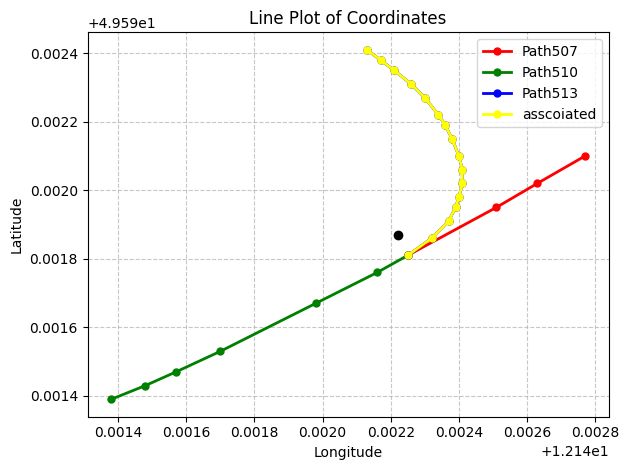

In [ ]:
import matplotlib.pyplot as plt
from itertools import cycle
color_cycle = cycle(['red', 'green', 'blue', 'orange', 'purple', 'cyan'])
asscoiatecond, coord = coordcheck(asscoiatedtopo['geometry']['coordinates'],signcord,20)
allpossibledict = []
if existingscore < 0.5 and observescore<0.5:
    print('sign do not exsit since both existingscore and observescore are below 0.5')
else:
    for i in range(0,len(topojson_data['features'])):
        condition, coord = coordcheck(topojson_data['features'][i]['geometry']['coordinates'],signcord,20)
        if condition:
            possibledict = {'asscoiate':False}
            temptopo = topojson_data['features'][i]
            if i == asscoiatedindex:
                possibledict['asscoiate'] = True
            possibledict['index'] = i
            possibledict['pedestrian'] = temptopo['properties']['accessCharacteristics'][0]['pedestrian']
            # print(temptopo['properties']['accessCharacteristics'][0]['pedestrian'])
            coordinates = temptopo['geometry']['coordinates']

            totaldis = 0
            dis=0
            for c in range(1,len(coordinates)):
                totaldis += haversine(coordinates[c-1][0], coordinates[c-1][1], coordinates[c][0], coordinates[c][1])
                if coord == coordinates[c]:
                    dis = totaldis
            offsetindex = dis/totaldis

            ranges = temptopo['properties']['topologyCharacteristics']['isMotorway']
            speedlimitrange = temptopo['properties']['speedLimit']
            result = find_matching_range(offsetindex, ranges)
            speedlimithw = find_matching_range_speedlimit(offsetindex,speedlimitrange)
            print(speedlimithw)
            filtered_probedf= filter_by_radius(probedf,coord[1],coord[0],20,10)
            print(not (filtered_probedf['speed'] < 10).any())
            print(result)
            possibledict['ismotorway'] = result or not (filtered_probedf['speed'] < 10).any() or speedlimithw
            x, y = zip(*coordinates)  # Unpack tuples into two lists
            allpossibledict.append(possibledict)
            # Plot
            plt.plot(x, y, 
                    color=next(color_cycle),
                    marker='o',      # Add markers at each point
                    linestyle='-',   # Solid line
                    linewidth=2,     # Thicker line
                    markersize=5,    # Size of markers
                    label='Path'+str(i))




    coordinates = asscoiatedtopo['geometry']['coordinates']
    x, y = zip(*coordinates)
    plt.plot(x, y, 
                    color='yellow', 
                    marker='o',      # Add markers at each point
                    linestyle='-',   # Solid line
                    linewidth=2,     # Thicker line
                    markersize=5,    # Size of markers
                    label='asscoiated')
    plt.plot(signcord[0],signcord[1],color='black',marker='o')
    # Customize the plot
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Line Plot of Coordinates')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [147]:
temptopo['properties']['speedLimit']

[{'confidence': {'featureType': 'ROAD_SPEED_LIMIT',
   'scoreType': 'EXISTENCE',
   'score': 0.0,
   'updateSource': 'INJECTION_TMOB',
   'updatedOn': '2018-05-01T00:00:00Z'},
  'range': {'endOffset': 1.0, 'startOffset': 0.0},
  'appliesTo': 'BOTH',
  'isUnlimited': True,
  'source': 'RAMP_UNPOSTED'}]

In [136]:
def validate_topology(topology_list):
    """
    Process topology list according to validation rules:
    1. If associated topology is motorway and pedestrian=True, correct pedestrian to False
    2. If associated topology ismotorway=False, find nearby motorway topology
    3. If no nearby motorway found, check probe data for pedestrians
    """
    
    # Case 1: Correct pedestrian flag for motorway segments
    for topo in topology_list:
        if topo['asscoiate'] and topo['ismotorway']:
            topo['pedestrian'] = False
            return (f"Case 3: Corrected pedestrian to False for motorway segment (index {topo['index']})")
    
    # Case 2: Find nearby motorway for non-motorway segments
    for topo in topology_list:
        if topo['ismotorway'] and not topo['pedestrian']:
            return (f"Case 2: Associated with the wrong road. The correct road (index {topo['index']})")
    
    return 'correct association, correct attribution​'

In [137]:
allpossibledict

[{'asscoiate': False, 'index': 507, 'pedestrian': False, 'ismotorway': False},
 {'asscoiate': False, 'index': 510, 'pedestrian': False, 'ismotorway': False},
 {'asscoiate': True, 'index': 513, 'pedestrian': True, 'ismotorway': False}]

In [138]:
validate_topology(allpossibledict)




'correct association, correct attribution\u200b'

Below is the probe solution

In [139]:
# for i in range(0,len(topojson_data['features'])):
#         condition, coord = coordcheck(topojson_data['features'][i]['geometry']['coordinates'],signcord,20)
#         if condition:
#             coordinates = topojson_data['features'][i]['geometry']['coordinates']
#             filtered_probedf= filter_by_radius(probedf,coord[1],coord[0],20,1)
#             print(coord)
#             print(filtered_probedf.shape)
#             if (filtered_probedf['speed'] < 10).any():
#                 print('not highway')
#             else:
#                 print('highway')
#             print(topojson_data['features'][i]['properties']['accessCharacteristics'][0]['pedestrian'])
#             # Unzip coordinates into separate X and Y lists
#             x, y = zip(*coordinates)  # Unpack tuples into two lists

#             # Plot
#             plt.plot(x, y, 
#                     color=next(color_cycle),
#                     marker='o',      # Add markers at each point
#                     linestyle='-',   # Solid line
#                     linewidth=2,     # Thicker line
#                     markersize=5,    # Size of markers
#                     label='Path')
#     coordinates = topojson_data['features'][676]['geometry']['coordinates']
#     x, y = zip(*coordinates)
#     # plt.plot(x, y, 
#     #                 color='yellow', 
#     #                 marker='o',      # Add markers at each point
#     #                 linestyle='-',   # Solid line
#     #                 linewidth=2,     # Thicker line
#     #                 markersize=5,    # Size of markers
#     #                 label='asscoiated')
#     plt.plot(signcord[0],signcord[1],color='black',marker='o')
#     # Customize the plot
#     plt.xlabel('Longitude')
#     plt.ylabel('Latitude')
#     plt.title('Line Plot of Coordinates')
#     plt.grid(True, linestyle='--', alpha=0.7)
#     plt.legend()
#     plt.tight_layout()
#     plt.show()